## Derivatives and Chain Rule

<div>
    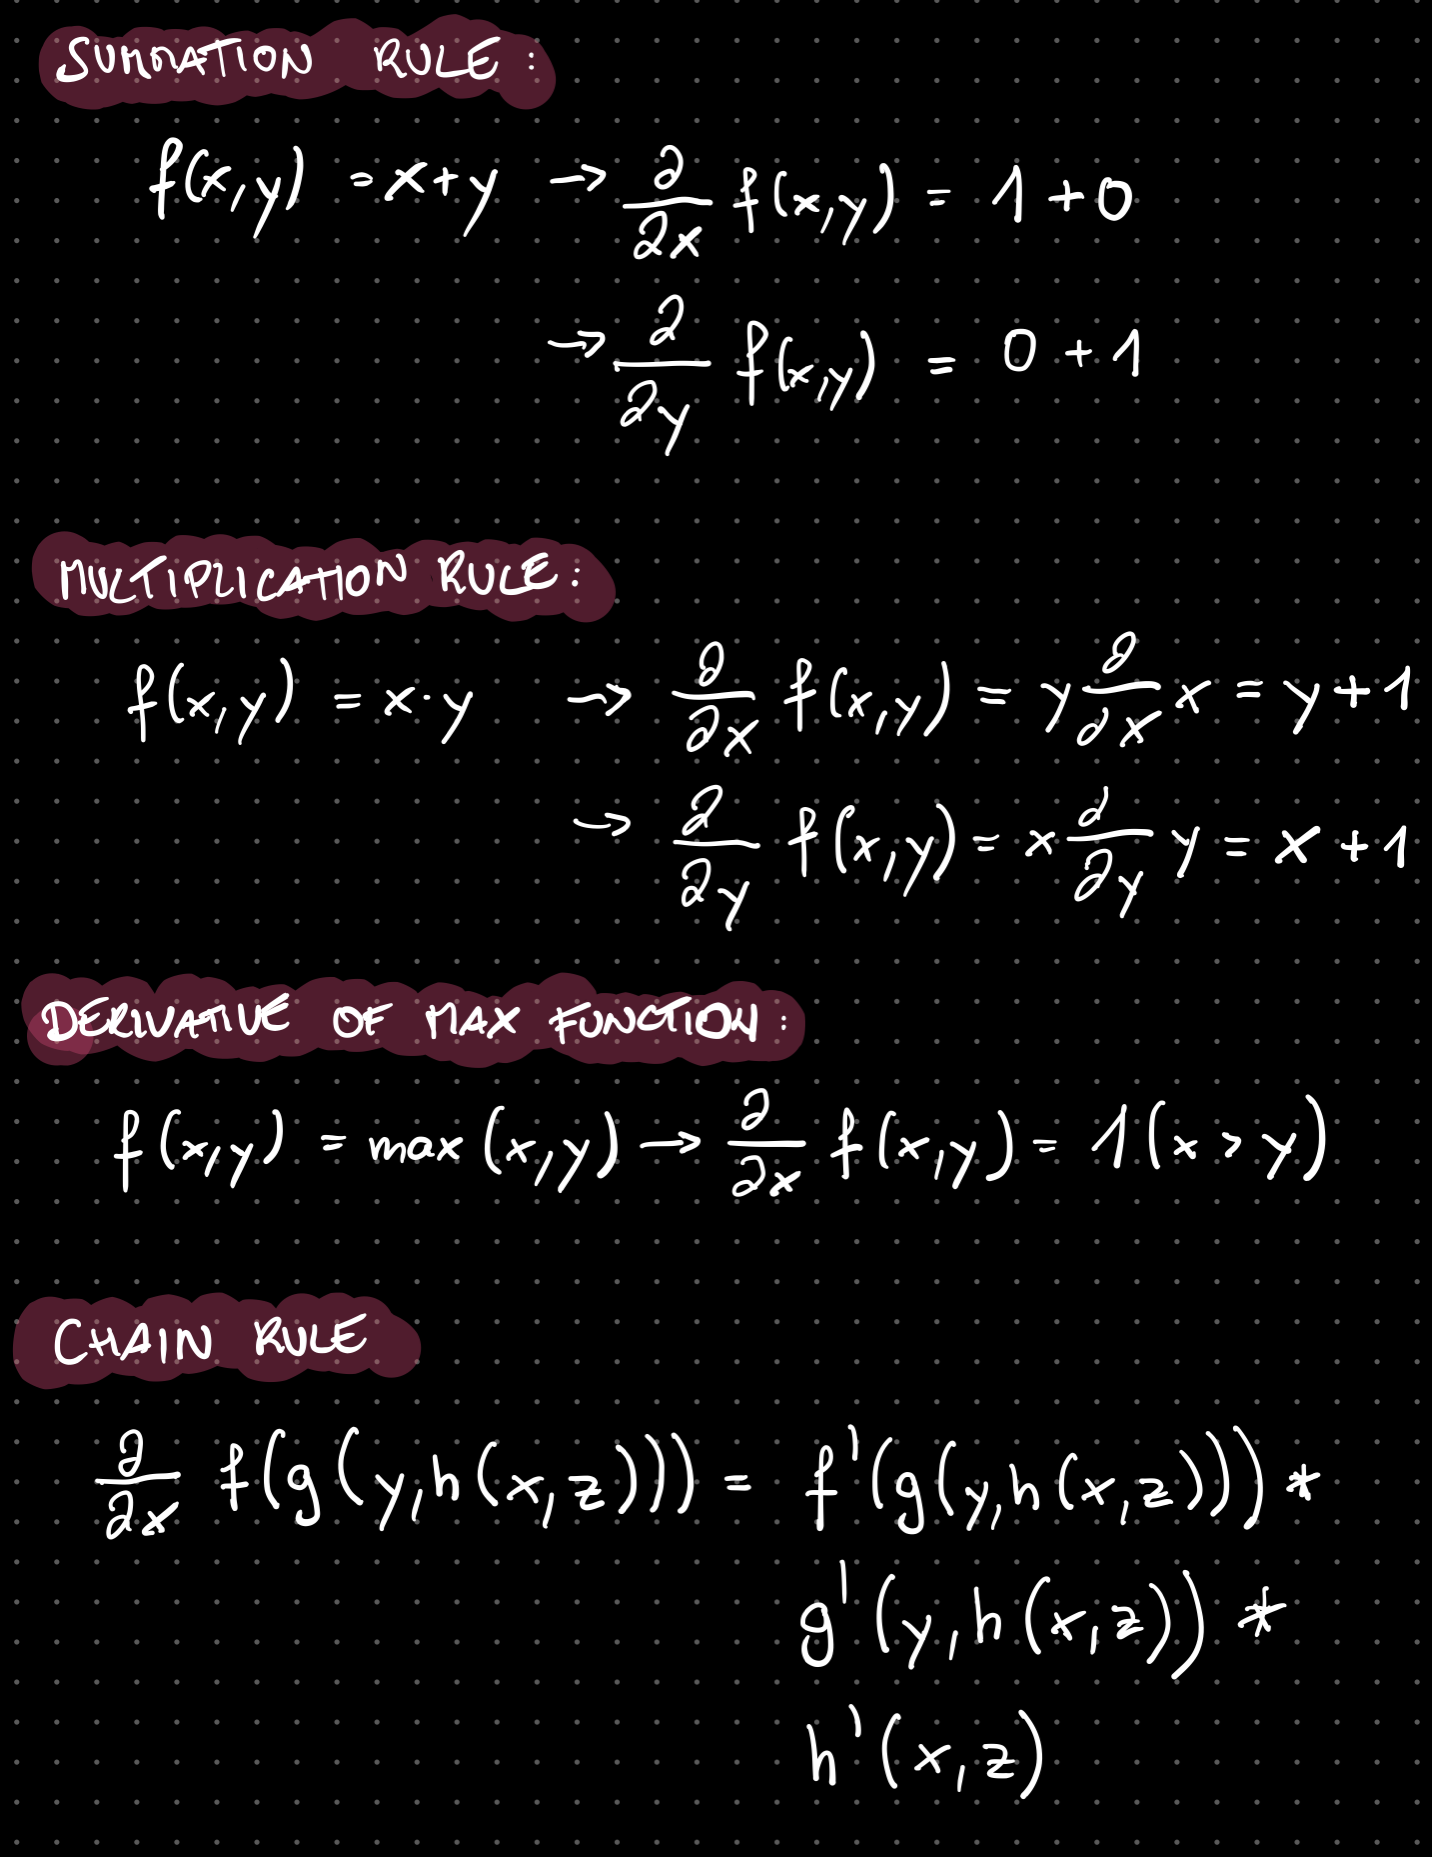
</div>

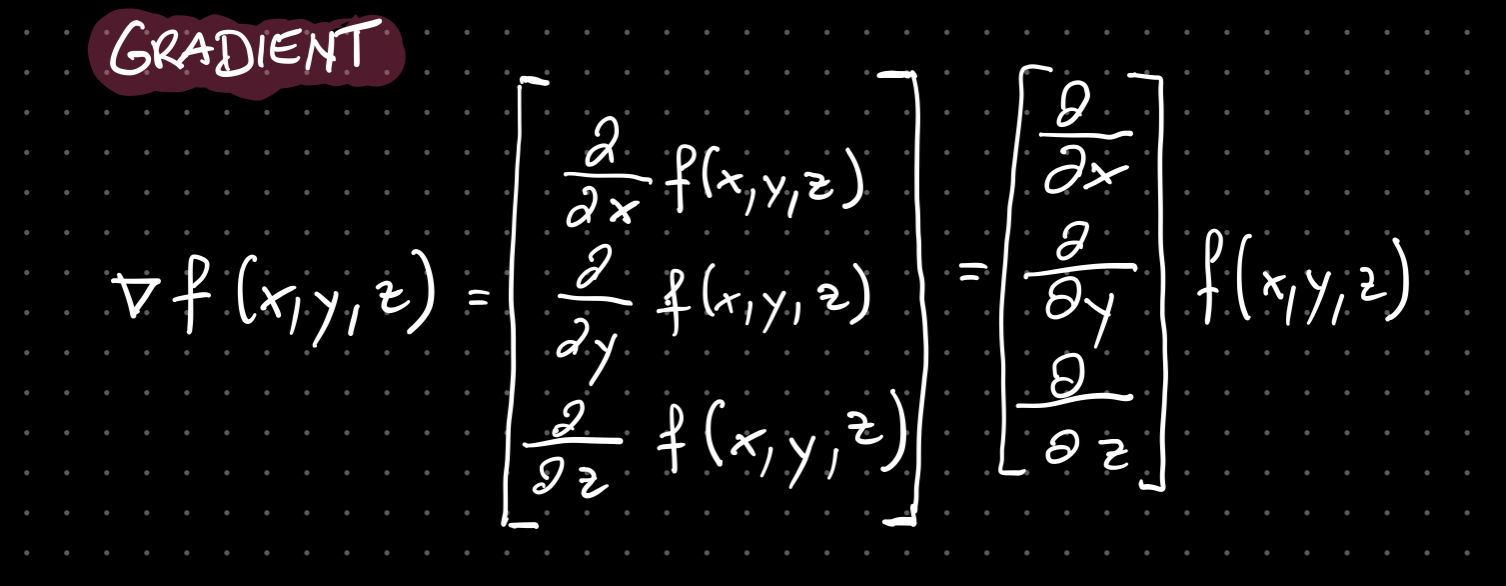

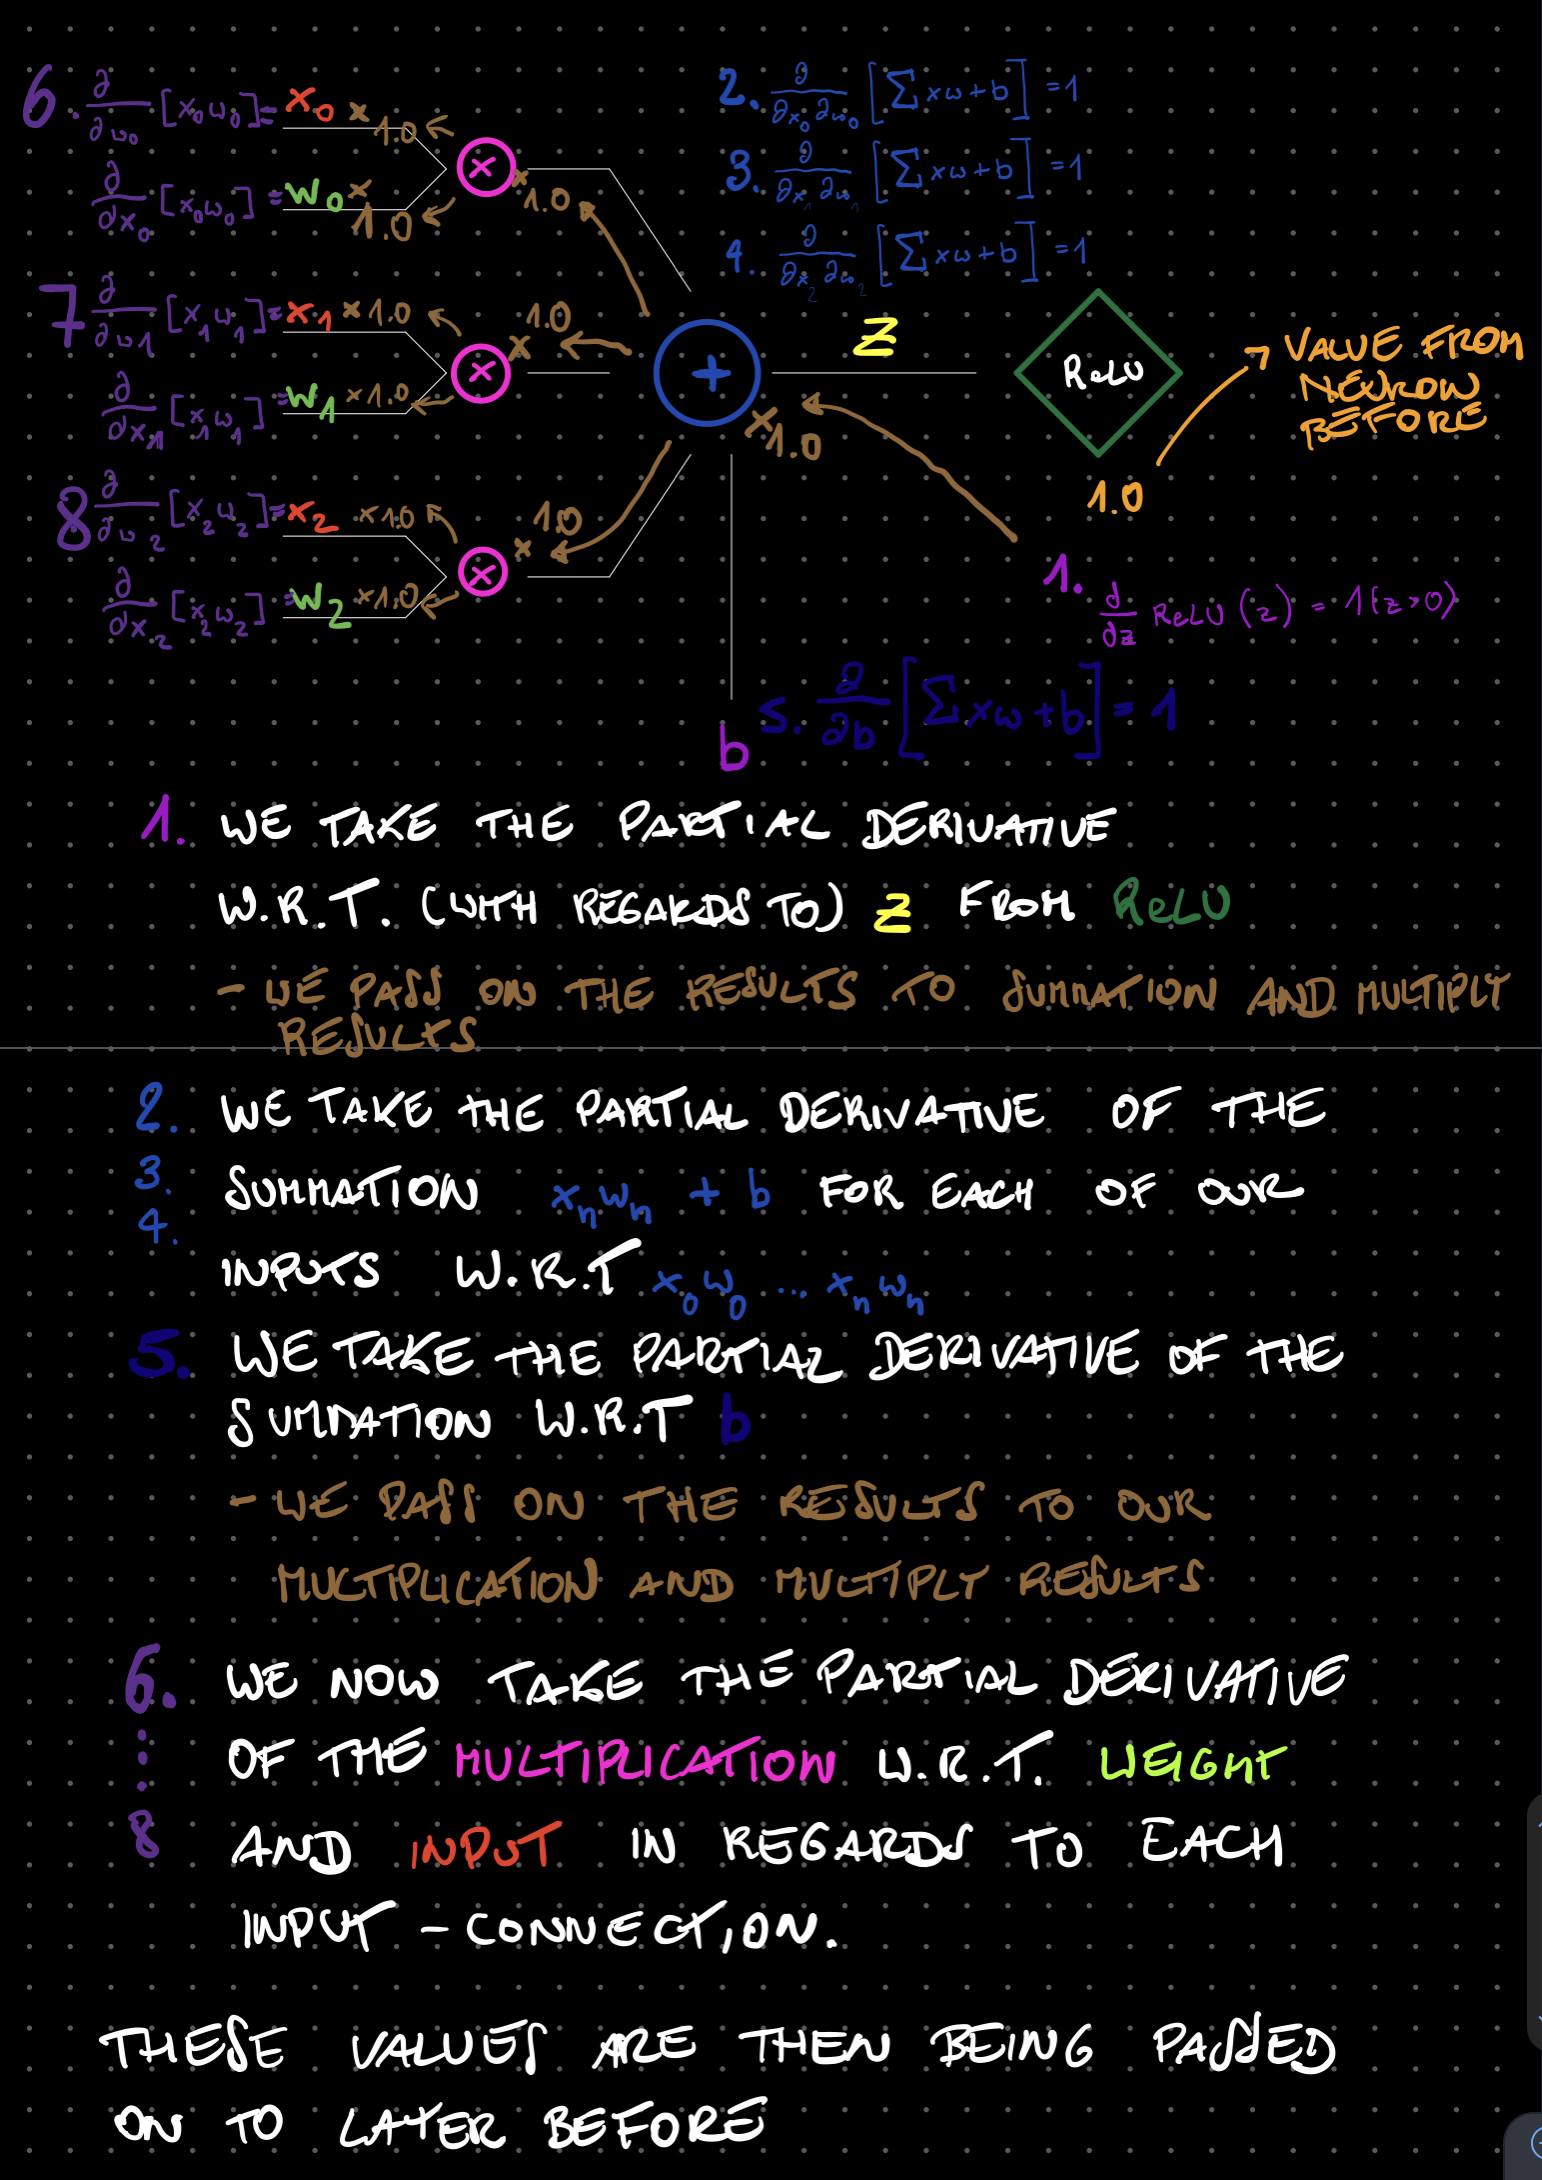

in order to calculate the impact of each node (weight * input + bias) we use partial derivatives using the chain rule which tells us that nested functions can simply be ***chained*** partial derivatives multiplied together. <br>
For one neuron we calculate the imact of the imput weight $w_0$ as follows, we calculate this across the whole network however.

$f'(x_0) = \frac{\partial}{\partial x_0}(mult(sum(ReLU(f'(x_1)))))$ = <br>
$f'(x_0) = x_n ... x_1 * \frac{\partial}{\partial z}ReLU(z) * \frac{\partial}{\partial x_0 \partial w_0}\sum{[x_0 * w_0 + b]} * \frac{\partial}{\partial x_0}[x_0*w_0] $

Besides the Neuron's internal weights and biases we also need to take the **partial derivatives** of the **activation functions (ReLU)** and **loss functions such as the CrossEntropy Loss and Softmax**

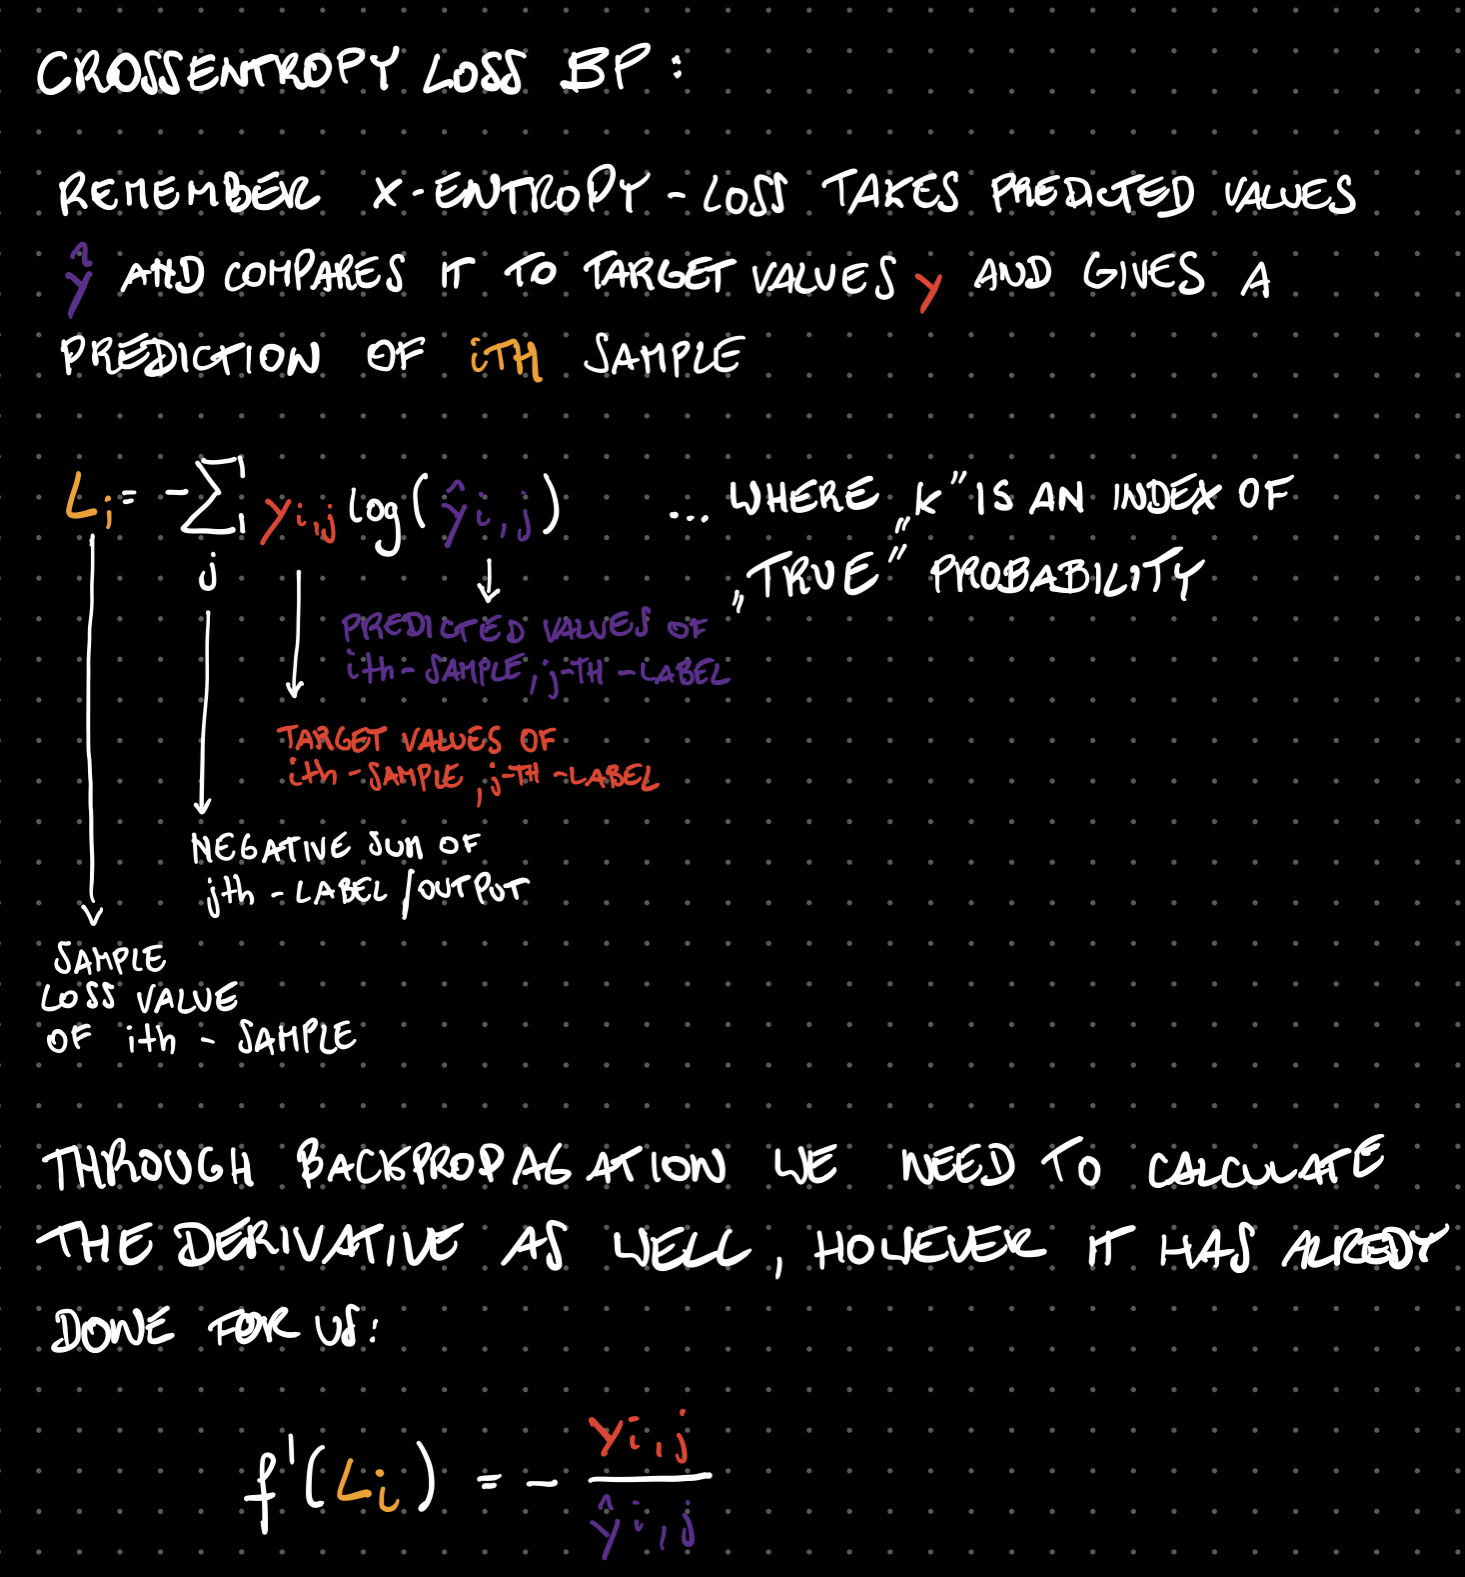

In [1]:
%%capture 
# we hide the output of the cell
# we simply import the previous chapter
%run -i Chapter_5B_All_Code.ipynb

In [2]:
import numpy as np

## Derivative of Softmax - implementation

$S_{i,j}=\dfrac{e^{z_{i,j}}}{\sum_{l=1}^L e^{z_{i,l}}} \longrightarrow f'(S_{i,j}) \longrightarrow S_{i,j}\delta_{i,j} - S_{i,j}S_{i,k}$

In [3]:
# example output of a softmax function for a forward pass
softmax_output = [0.7, 0.1, 0.2]

softmax_output = np.array(softmax_output).reshape(-1, 1)
softmax_output

array([[0.7],
       [0.1],
       [0.2]])

$f'(softmax) = S_{i,j}\delta_{i,j} - S_{i,j}S_{i,k}$

$\delta$ - Kronecker Delta: <p> 

\begin{equation}
  \delta_{i,j} =
    \begin{cases}
      1 & i = j\\
      0 & i \neq j\\
    \end{cases}       
\end{equation}

The implementation of $S_{i,j}\delta_{i,j}$ <br>
We take the output of Softmax and make *one-hot* vectors with the values, so that it conforms with the *Kronecker delta* - $\delta$

$\delta_{i,j}$ :

In [4]:
kronecker = np.eye(softmax_output.shape[0])
kronecker

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

$S_{i,j}$ :

In [5]:
S_ij_D_ij = softmax_output * kronecker
S_ij_D_ij

array([[0.7, 0. , 0. ],
       [0. , 0.1, 0. ],
       [0. , 0. , 0.2]])

$-S_{i,j}S_{i,k} :$

In [6]:
S_ij_S_ik = softmax_output @ softmax_output.T
S_ij_S_ik

array([[0.49, 0.07, 0.14],
       [0.07, 0.01, 0.02],
       [0.14, 0.02, 0.04]])

$f'(softmax) = S_{i,j}\delta_{i,j} - S_{i,j}S_{i,k}$

In [7]:
d_softmax = S_ij_D_ij - S_ij_S_ik
d_softmax

array([[ 0.21, -0.07, -0.14],
       [-0.07,  0.09, -0.02],
       [-0.14, -0.02,  0.16]])

This $f'(softmax)$ i called the **Jacobian Matrix** represents in this example **all the combinations of partial derivatives** of our two input vectors (size 3). <br> Since we want to know **how much influence does one parameter have in regards to all of the other parameters**. <br>
The total size of the Jacobian matrix can be calculated by $softmax vec size^2$

### Code

In [8]:
# Softmax activation
class Activation_Softmax:
...
    # Backward pass
    def backward(self, dvalues):
    # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
    # Enumerate outputs and gradients
    for index, (single_output, single_dvalues) in \
        enumerate(zip(self.output, dvalues)):
        # Flatten output array
    single_output = single_output.reshape(-1, 1)
    # Calculate Jacobian matrix of the output
    jacobian_matrix = np.diagflat(single_output) - \
                      np.dot(single_output, single_output.T)
    # Calculate sample-wise gradient
    # and add it to the array of sample gradients
    self.dinputs[index] = np.dot(jacobian_matrix,
                                 single_dvalues)

IndentationError: expected an indented block (<ipython-input-8-0a12ffb87dd1>, line 3)

## Derivative of Cross Entropy Loss - implementation

$L_{i}=-\sum\limits_{j}y_{i,j}log(\hat{y}_{i,j})  \longrightarrow f'(L_{i})  \longrightarrow - \dfrac{y_{i,j}}{\hat{y}_{i,j}}$

$\hat{y}_{i,j}$ ... the predicted Softmax probabilities <br>
${y}_{i,j}$ ... ground truth as one-hot vectors

In [ ]:
len_dvals = 5 # the length of the probabilities from softmax
one_hot_vecs = np.eye(len_dvals)
one_hot_vecs

then we can do a simple division and negate it.

### Code

In [ ]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):
...
# Backward pass
def backward(self, dvalues, y_true):
    # Number of samples
    samples = len(dvalues)
    # Number of labels in every sample
    # We'll use the first sample to count them
    labels = len(dvalues[0])
    # If labels are sparse, turn them into one-hot vector
    if len(y_true.shape) == 1:
        y_true = np.eye(labels)[y_true]
    # Calculate gradient
    self.dinputs = -y_true / dvalues
    # Normalize gradient
    self.dinputs = self.dinputs / samples

## Cross Entropy Loss and Softmax Activation derivative - implementation

To speed up the calculation however we can combine the Softmax derivative and the CrossEntropy Loss derivative in one step. **We take the partial derivative of Crossentropy-Loss function in respect to the Softmax inputs**:

$ \frac{\partial L_{i}}{\partial z_{i,j}} = \hat{y}_{i,k} - y_{i,k}$

In [ ]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
# Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
        y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

## Gradients

Like described above the gradient is a vector of size n - depending on the neurons in that layer, containing the partial derivatives of **weights** and **biases**. Now we need to use ***SGD (Stochastic gradient descent) to update the weights and biases.  